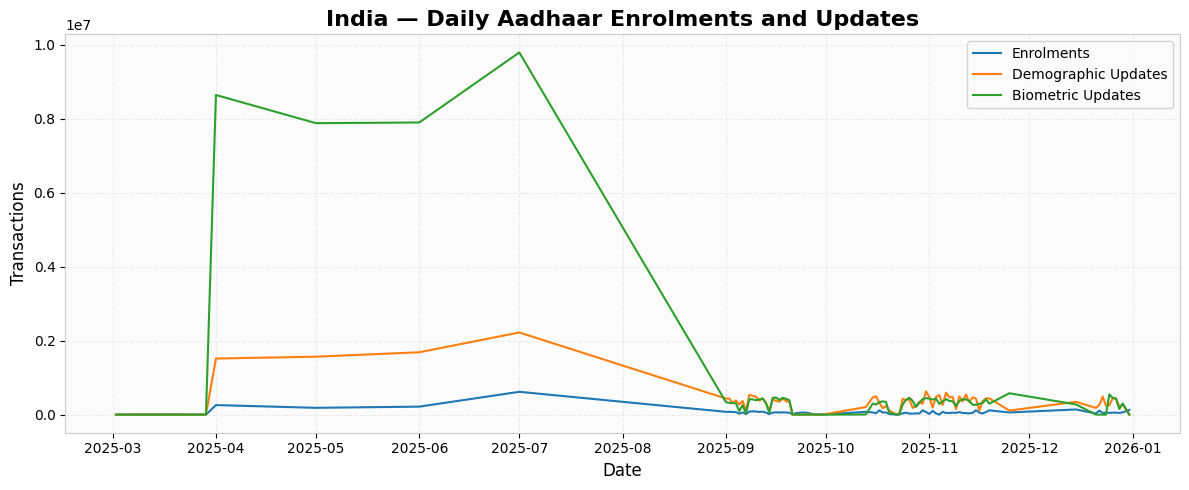

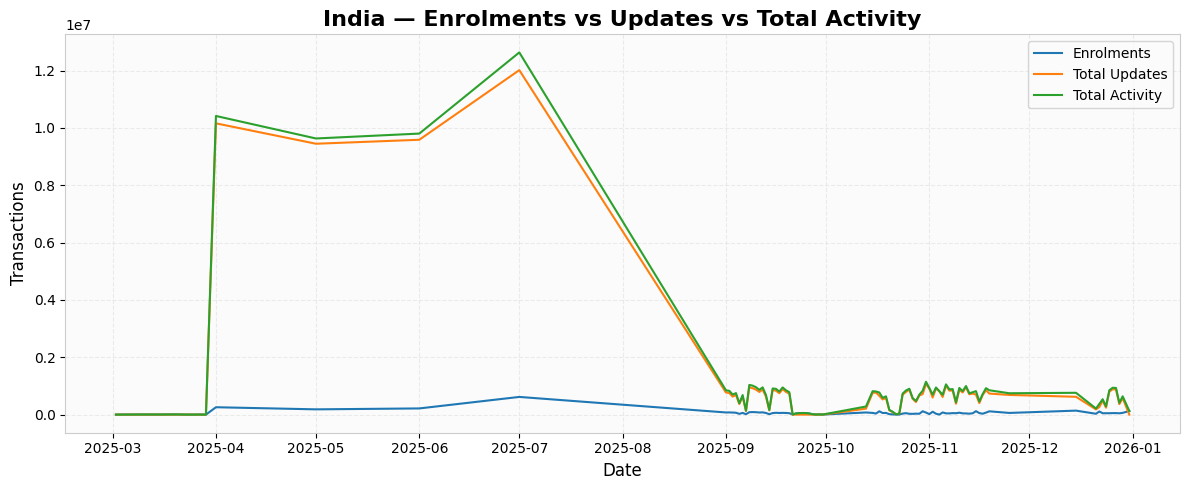

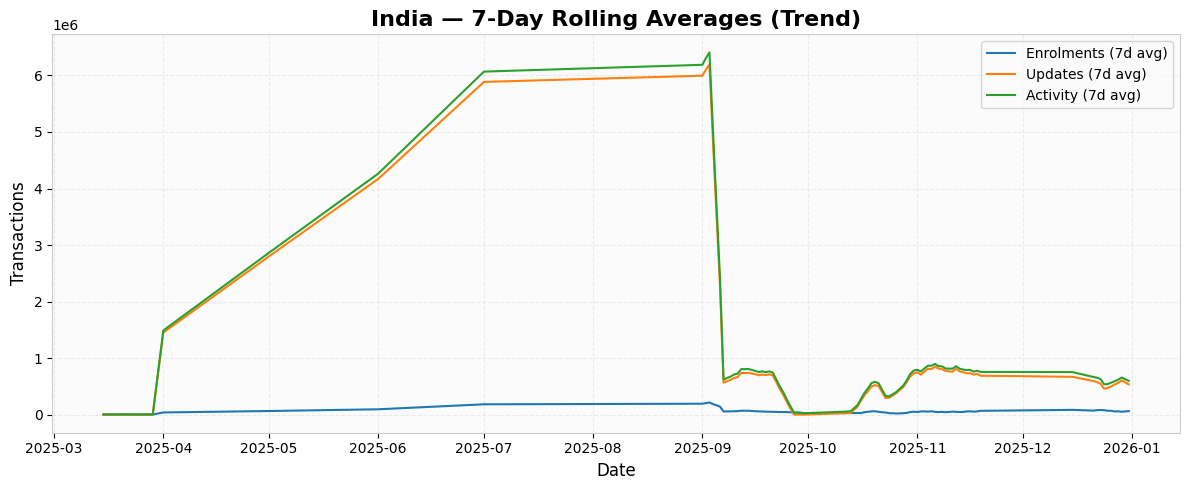

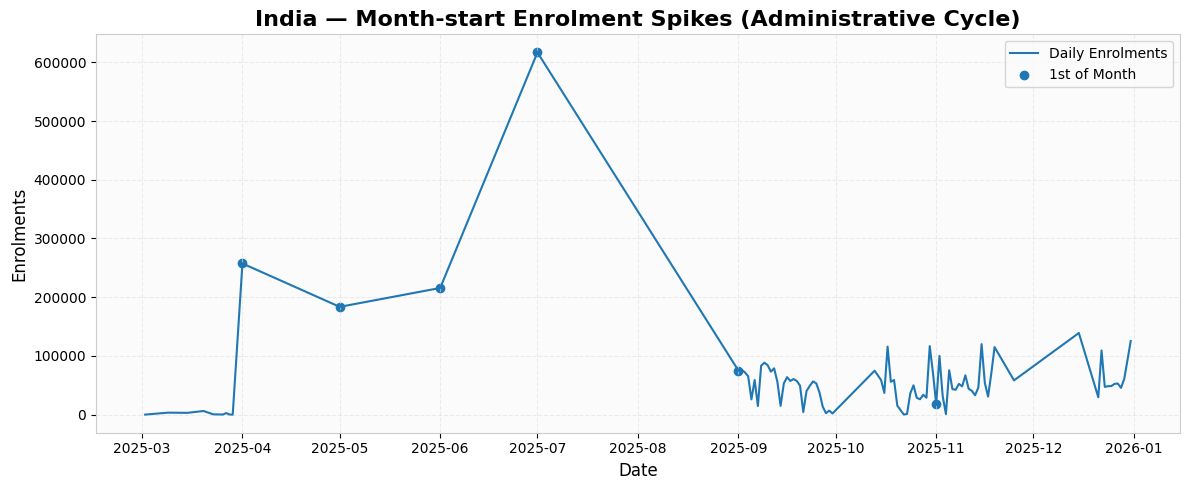

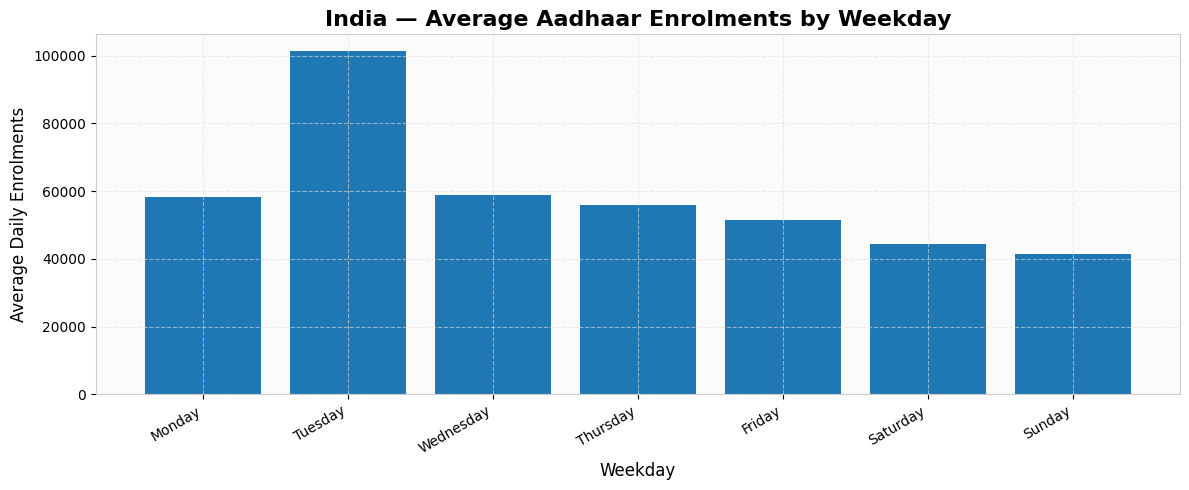

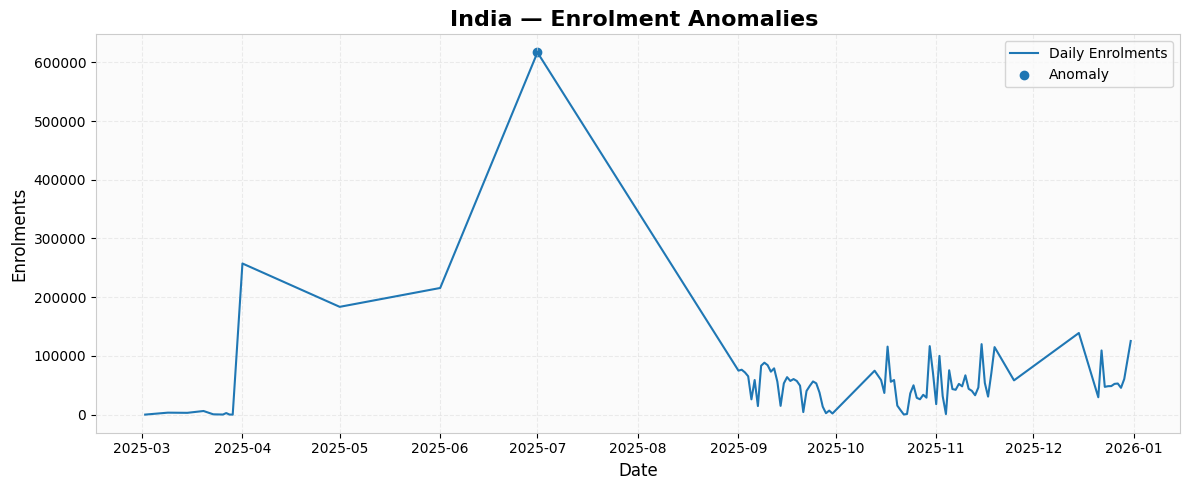

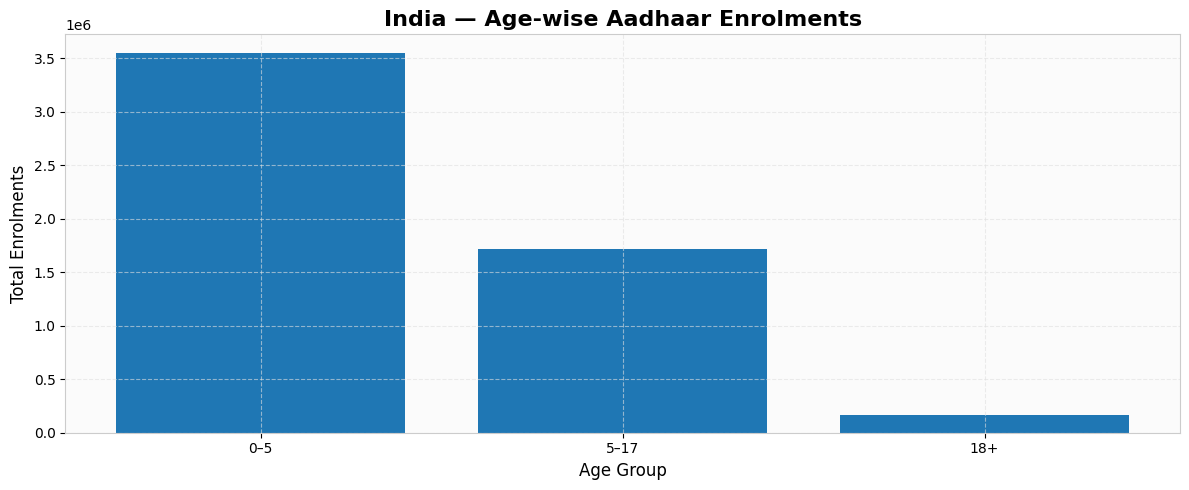

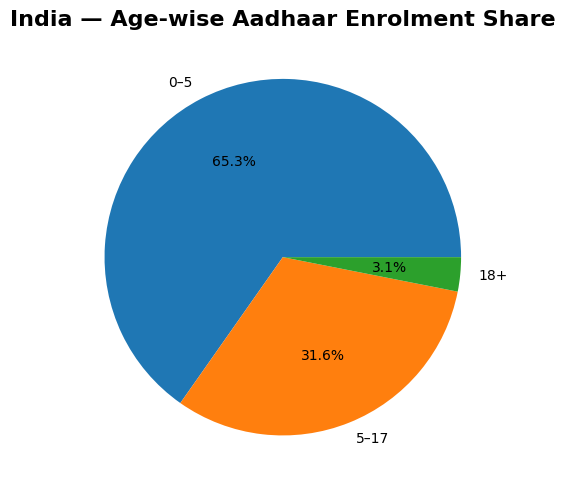

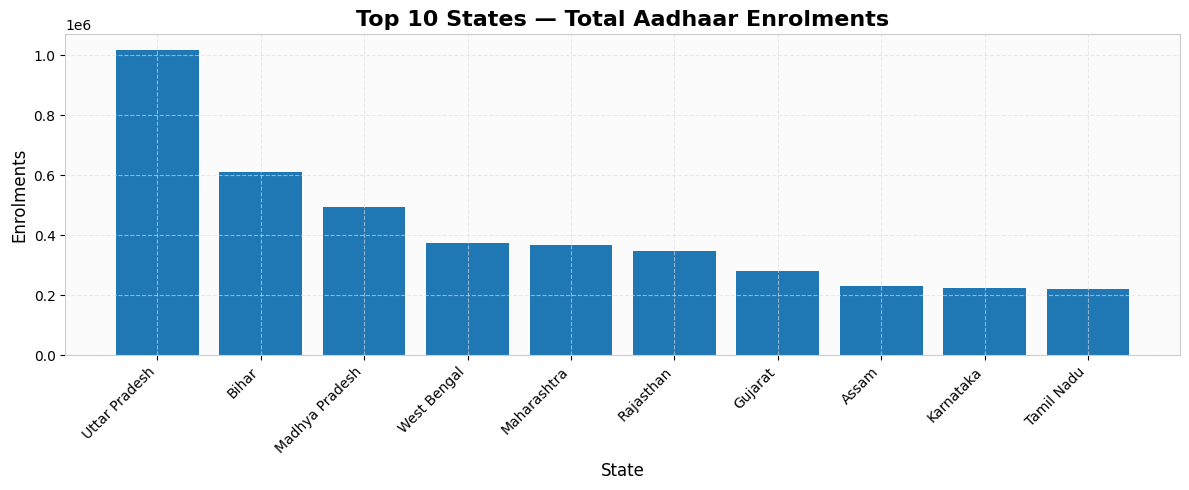

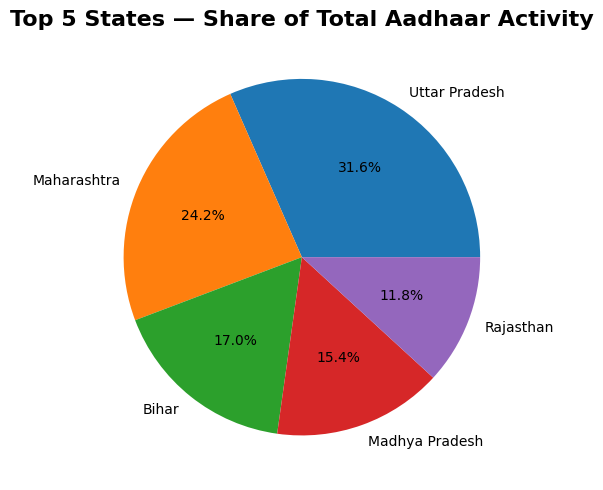

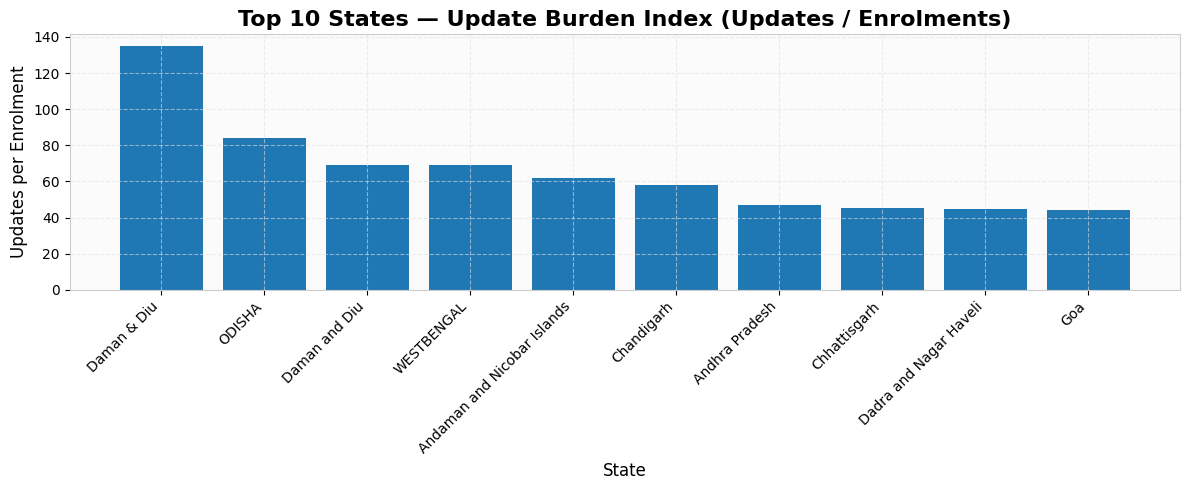

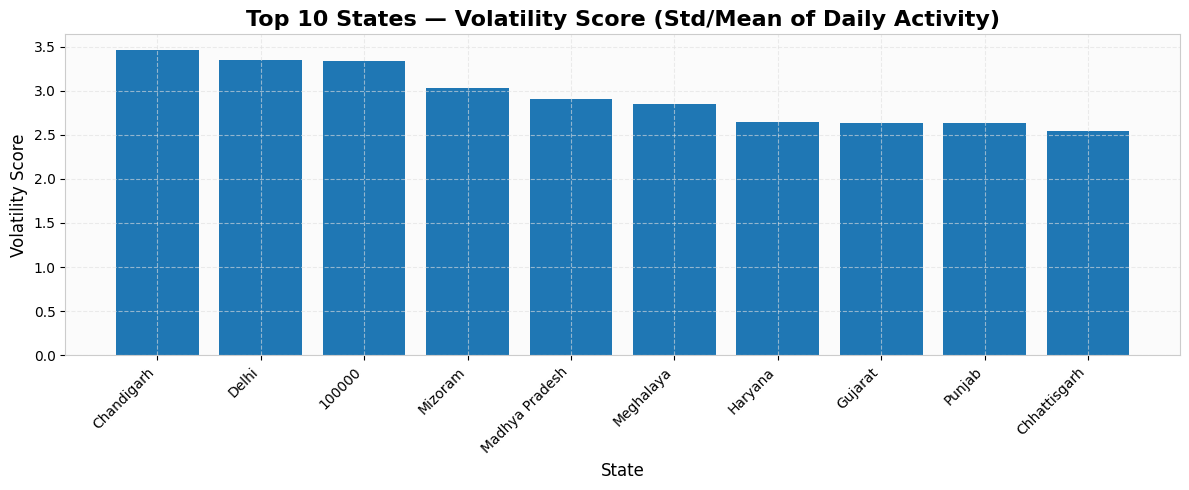

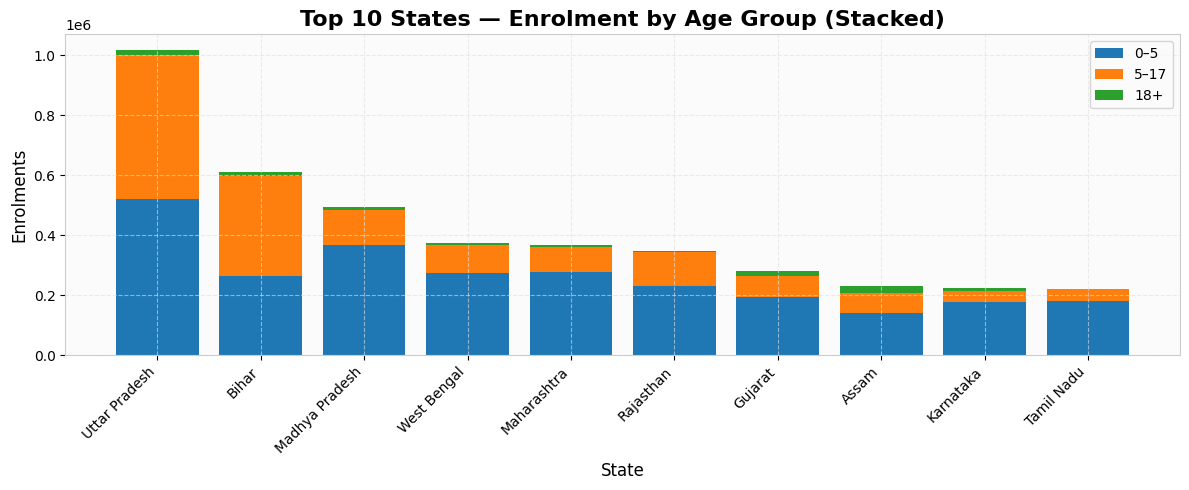

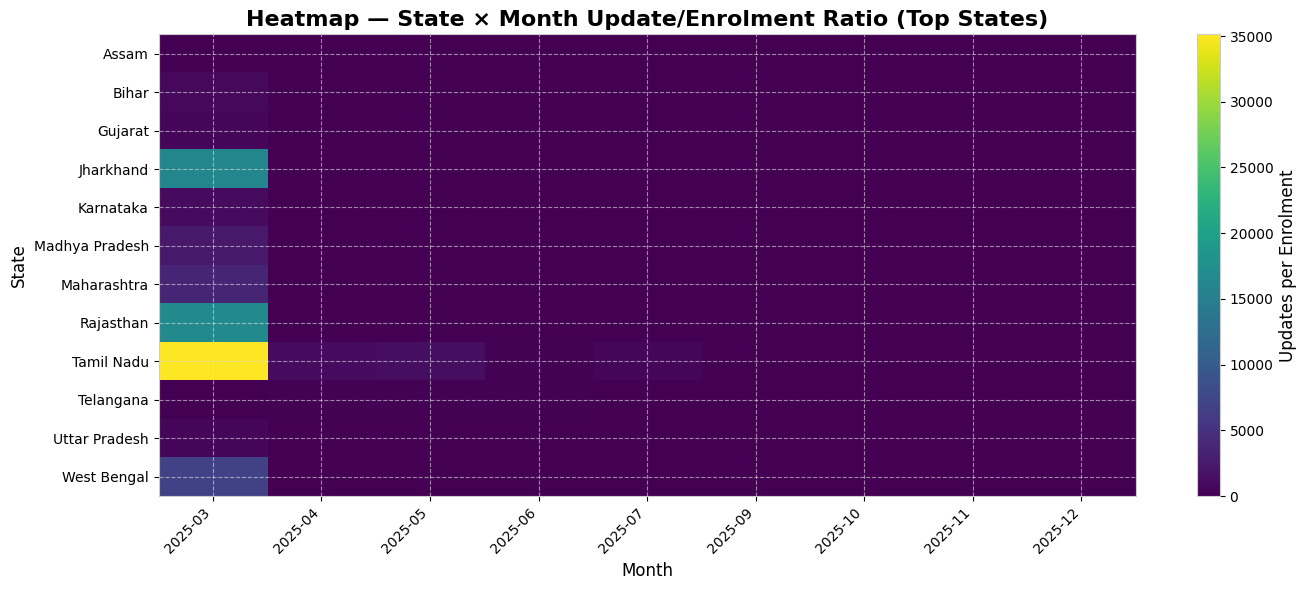

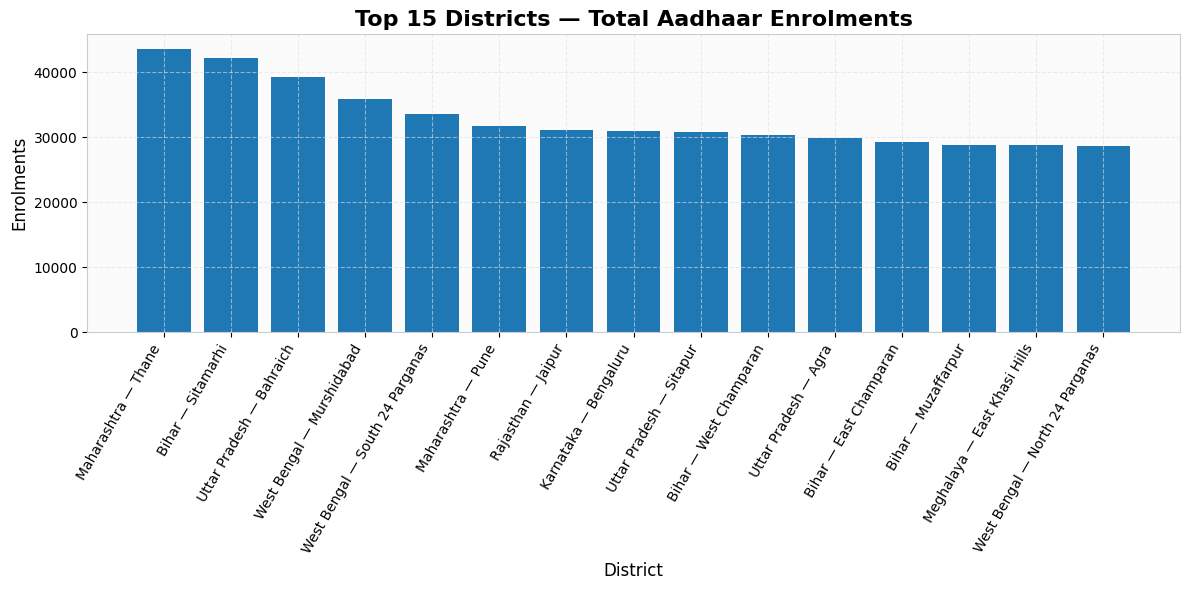

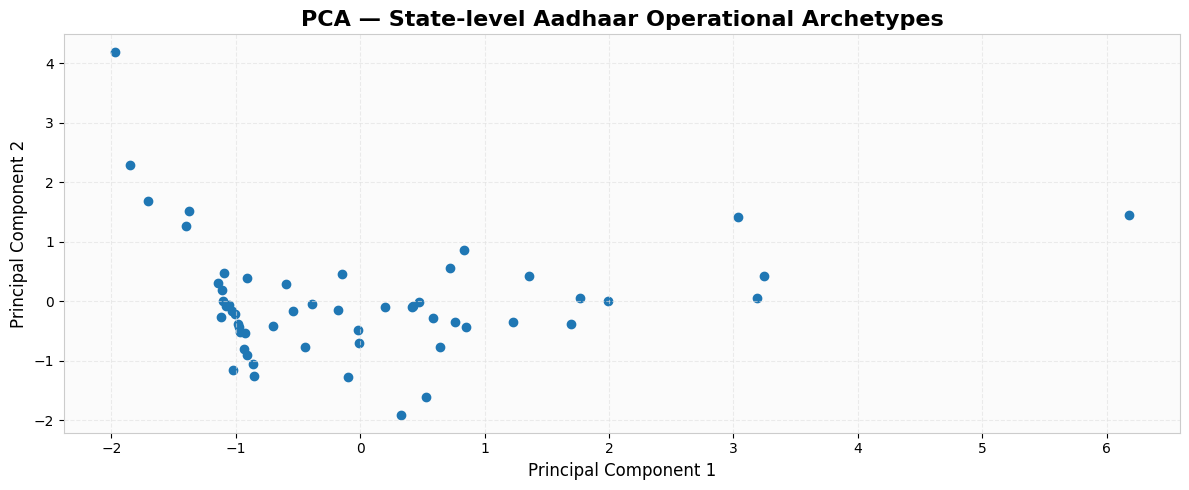

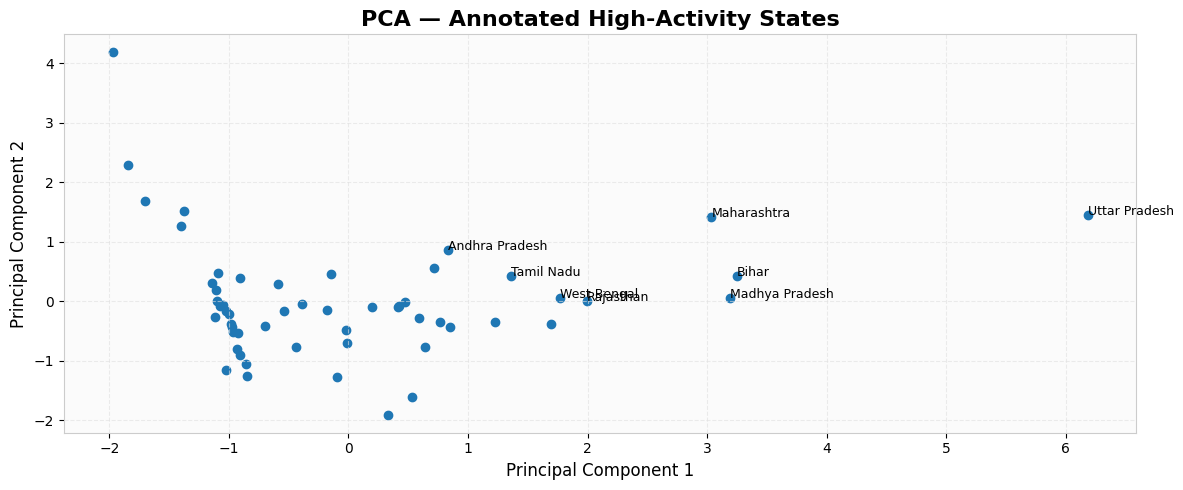

Done. Set SAVE_FIGS=True to export all figures to: /mnt/data/aadhaar_figs


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# -------------------------
# CONFIG (use your local names OR absolute paths)
# -------------------------
ENROL_PATH = "api_data_aadhar_enrolment_0_1006029.csv"
DEMO_PATH  = "api_data_aadhar_demographic_0_2071700.csv"
BIO_PATH   = "api_data_aadhar_biometric_0_1861108.csv"

SAVE_FIGS = False
OUTDIR = "/mnt/data/aadhaar_figs"
os.makedirs(OUTDIR, exist_ok=True)

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

def savefig(name: str):
    if SAVE_FIGS:
        fp = os.path.join(OUTDIR, name)
        plt.savefig(fp, dpi=220, bbox_inches="tight")
        print("Saved:", fp)

# -------------------------
# LOAD + CLEAN
# -------------------------
def load_uidai_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Drop common index-like column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Clean column names
    df.columns = [c.strip() for c in df.columns]

    # Date parse
    if "date" not in df.columns:
        raise ValueError(f"Missing 'date' column in {path}")
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")

    # Strip common geo fields if present
    for c in ["state", "district", "pincode"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    return df

enrol = load_uidai_csv(ENROL_PATH)
demo  = load_uidai_csv(DEMO_PATH)
bio   = load_uidai_csv(BIO_PATH)

# -------------------------
# FEATURE ENGINEERING
# -------------------------
# totals (enrol)
enrol["total_enrol"] = (
    enrol[["age_0_5", "age_5_17", "age_18_greater"]]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .sum(axis=1)
)

# demo/bio columns vary; sum all columns starting with demo_ / bio_
demo_cols = [c for c in demo.columns if c.startswith("demo_")]
bio_cols  = [c for c in bio.columns  if c.startswith("bio_")]

if not demo_cols:
    raise ValueError(f"No demo_ columns found in demographic dataset. Columns: {list(demo.columns)}")
if not bio_cols:
    raise ValueError(f"No bio_ columns found in biometric dataset. Columns: {list(bio.columns)}")

demo["total_demo"] = demo[demo_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
bio["total_bio"]   = bio[bio_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)

eps = 1e-9

# ============================================================
# INDIA DAILY TABLE
# ============================================================
daily = (
    enrol.groupby("date")["total_enrol"].sum().to_frame("Enrolments")
    .join(demo.groupby("date")["total_demo"].sum())
    .join(bio.groupby("date")["total_bio"].sum())
    .fillna(0)
)

daily.rename(
    columns={"total_demo": "Demographic Updates", "total_bio": "Biometric Updates"},
    inplace=True
)

daily["Total Updates"] = daily["Demographic Updates"] + daily["Biometric Updates"]
daily["Total Activity"] = daily["Enrolments"] + daily["Total Updates"]

daily["Enrol_7d_avg"] = daily["Enrolments"].rolling(7, min_periods=3).mean()
daily["Upd_7d_avg"]   = daily["Total Updates"].rolling(7, min_periods=3).mean()
daily["Act_7d_avg"]   = daily["Total Activity"].rolling(7, min_periods=3).mean()

daily["is_month_start"] = daily.index.is_month_start
daily["weekday"] = daily.index.day_name()

# ============================================================
# 1) Time-series: Daily enrolments + demo + bio updates
# ============================================================
plt.figure()
plt.plot(daily.index, daily["Enrolments"], label="Enrolments")
plt.plot(daily.index, daily["Demographic Updates"], label="Demographic Updates")
plt.plot(daily.index, daily["Biometric Updates"], label="Biometric Updates")
plt.title("India — Daily Aadhaar Enrolments and Updates")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.tight_layout()
savefig("01_india_daily_enrol_demo_bio.png")
plt.show()

# ============================================================
# 2) Time-series: Enrolments vs Total Updates vs Total Activity
# ============================================================
plt.figure()
plt.plot(daily.index, daily["Enrolments"], label="Enrolments")
plt.plot(daily.index, daily["Total Updates"], label="Total Updates")
plt.plot(daily.index, daily["Total Activity"], label="Total Activity")
plt.title("India — Enrolments vs Updates vs Total Activity")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.tight_layout()
savefig("02_india_enrol_vs_updates_vs_activity.png")
plt.show()

# ============================================================
# 3) Rolling averages (trend vs noise)
# ============================================================
plt.figure()
plt.plot(daily.index, daily["Enrol_7d_avg"], label="Enrolments (7d avg)")
plt.plot(daily.index, daily["Upd_7d_avg"], label="Updates (7d avg)")
plt.plot(daily.index, daily["Act_7d_avg"], label="Activity (7d avg)")
plt.title("India — 7-Day Rolling Averages (Trend)")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.legend()
plt.tight_layout()
savefig("03_india_rolling_7d.png")
plt.show()

# ============================================================
# 4) Annotated: Month-start enrolment spikes
# ============================================================
plt.figure()
plt.plot(daily.index, daily["Enrolments"], label="Daily Enrolments")
ms = daily[daily["is_month_start"]]
plt.scatter(ms.index, ms["Enrolments"], label="1st of Month")
plt.title("India — Month-start Enrolment Spikes (Administrative Cycle)")
plt.xlabel("Date")
plt.ylabel("Enrolments")
plt.legend()
plt.tight_layout()
savefig("04_month_start_spikes.png")
plt.show()

# ============================================================
# 5) Average Aadhaar enrolment by weekday (NEW)
# ============================================================
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
avg_weekday = daily.groupby("weekday")["Enrolments"].mean().reindex(weekday_order)

plt.figure()
plt.bar(avg_weekday.index, avg_weekday.values)
plt.title("India — Average Aadhaar Enrolments by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Daily Enrolments")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
savefig("05_avg_enrol_by_weekday.png")
plt.show()

# ============================================================
# 6) Anomaly plot (global z-score) for enrolments
# ============================================================
s = daily["Enrolments"].astype(float)
mu, sigma = s.mean(), s.std(ddof=0)
sigma = sigma if (sigma and not np.isnan(sigma)) else 1.0
z = (s - mu) / sigma
anom = z.abs() >= 3.0

plt.figure()
plt.plot(daily.index, s, label="Daily Enrolments")
plt.scatter(daily.index[anom], s[anom], label="Anomaly")
plt.title("India — Enrolment Anomalies ")
plt.xlabel("Date")
plt.ylabel("Enrolments")
plt.legend()
plt.tight_layout()
savefig("06_anomaly_global_z.png")
plt.show()

# ============================================================
# 7) Age-wise enrolments (bar)
# ============================================================
age_totals = enrol[["age_0_5", "age_5_17", "age_18_greater"]].apply(pd.to_numeric, errors="coerce").fillna(0).sum()

plt.figure()
plt.bar(["0–5", "5–17", "18+"], age_totals.values)
plt.title("India — Age-wise Aadhaar Enrolments")
plt.xlabel("Age Group")
plt.ylabel("Total Enrolments")
plt.tight_layout()
savefig("07_agewise_enrol_bar.png")
plt.show()

# ============================================================
# 8) Age-wise share (pie)
# ============================================================
plt.figure()
plt.pie(age_totals.values, labels=["0–5", "5–17", "18+"], autopct="%1.1f%%")
plt.title("India — Age-wise Aadhaar Enrolment Share")
plt.tight_layout()
savefig("08_agewise_enrol_pie.png")
plt.show()

# ============================================================
# STATE-LEVEL TABLES (regional variation, burden, activity share)
# ============================================================
state = (
    enrol.groupby("state")["total_enrol"].sum().to_frame("Enrol")
    .join(demo.groupby("state")["total_demo"].sum())
    .join(bio.groupby("state")["total_bio"].sum())
    .fillna(0)
)
state.rename(columns={"total_demo": "Demo", "total_bio": "Bio"}, inplace=True)
state["Updates"] = state["Demo"] + state["Bio"]
state["Total Activity"] = state["Enrol"] + state["Updates"]
state["Update Burden Index"] = state["Updates"] / (state["Enrol"] + eps)

# ============================================================
# 9) Top states by total enrolments (bar ranking)
# ============================================================
top_enrol_states = state.sort_values("Enrol", ascending=False).head(10)

plt.figure()
plt.bar(top_enrol_states.index, top_enrol_states["Enrol"])
plt.title("Top 10 States — Total Aadhaar Enrolments")
plt.xlabel("State")
plt.ylabel("Enrolments")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
savefig("09_top10_states_enrol.png")
plt.show()

# ============================================================
# 10) Top states: share of total Aadhaar activity (pie)
# ============================================================
top5_activity = state.sort_values("Total Activity", ascending=False).head(5)

plt.figure()
plt.pie(top5_activity["Total Activity"].values, labels=top5_activity.index, autopct="%1.1f%%")
plt.title("Top 5 States — Share of Total Aadhaar Activity")
plt.tight_layout()
savefig("10_top5_state_activity_share.png")
plt.show()

# ============================================================
# 11) Update Burden Index (bar ranking)
# ============================================================
top_burden = state.sort_values("Update Burden Index", ascending=False).head(10)

plt.figure()
plt.bar(top_burden.index, top_burden["Update Burden Index"])
plt.title("Top 10 States — Update Burden Index (Updates / Enrolments)")
plt.xlabel("State")
plt.ylabel("Updates per Enrolment")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
savefig("11_top10_update_burden.png")
plt.show()

# ============================================================
# 12) Volatility Score (std/mean of DAILY activity at state level)
# ============================================================
state_day_enrol = enrol.groupby(["state", "date"])["total_enrol"].sum().reset_index()
state_day_demo  = demo.groupby(["state", "date"])["total_demo"].sum().reset_index()
state_day_bio   = bio.groupby(["state", "date"])["total_bio"].sum().reset_index()

state_day = (
    state_day_enrol.merge(state_day_demo, on=["state","date"], how="left")
                  .merge(state_day_bio,  on=["state","date"], how="left")
                  .fillna(0)
)
state_day["activity"] = state_day["total_enrol"] + state_day["total_demo"] + state_day["total_bio"]

vol = state_day.groupby("state")["activity"].agg(["mean","std"]).fillna(0)
vol["Volatility Score"] = vol["std"] / (vol["mean"] + eps)

top_vol = vol.sort_values("Volatility Score", ascending=False).head(10)

plt.figure()
plt.bar(top_vol.index, top_vol["Volatility Score"])
plt.title("Top 10 States — Volatility Score (Std/Mean of Daily Activity)")
plt.xlabel("State")
plt.ylabel("Volatility Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
savefig("12_top10_volatility.png")
plt.show()

# ============================================================
# 13) Stacked bars: Top states × age group (trivariate)
# ============================================================
state_age = enrol.groupby("state")[["age_0_5","age_5_17","age_18_greater"]].apply(
    lambda x: x.apply(pd.to_numeric, errors="coerce").fillna(0).sum()
)
state_age["total"] = state_age.sum(axis=1)
state_age = state_age.sort_values("total", ascending=False).head(10)

x = np.arange(len(state_age.index))
plt.figure(figsize=(12,5))
plt.bar(x, state_age["age_0_5"].values, label="0–5")
plt.bar(x, state_age["age_5_17"].values, bottom=state_age["age_0_5"].values, label="5–17")
plt.bar(
    x,
    state_age["age_18_greater"].values,
    bottom=(state_age["age_0_5"] + state_age["age_5_17"]).values,
    label="18+"
)
plt.title("Top 10 States — Enrolment by Age Group (Stacked)")
plt.xlabel("State")
plt.ylabel("Enrolments")
plt.xticks(x, state_age.index, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
savefig("13_stacked_age_top10.png")
plt.show()

enrol_m = enrol.copy()
demo_m  = demo.copy()
bio_m   = bio.copy()

enrol_m["month"] = enrol_m["date"].dt.to_period("M").astype(str)
demo_m["month"]  = demo_m["date"].dt.to_period("M").astype(str)
bio_m["month"]   = bio_m["date"].dt.to_period("M").astype(str)

em = enrol_m.groupby(["state","month"])["total_enrol"].sum().reset_index()
dm = demo_m.groupby(["state","month"])["total_demo"].sum().reset_index()
bm = bio_m.groupby(["state","month"])["total_bio"].sum().reset_index()

sm = em.merge(dm, on=["state","month"], how="left").merge(bm, on=["state","month"], how="left").fillna(0)
sm["updates"] = sm["total_demo"] + sm["total_bio"]
sm["ratio"] = sm["updates"] / (sm["total_enrol"] + eps)

top_states = sm.groupby("state")["total_enrol"].sum().sort_values(ascending=False).head(12).index
pivot = sm[sm["state"].isin(top_states)].pivot(index="state", columns="month", values="ratio").fillna(0)

plt.figure(figsize=(14,6))
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap — State × Month Update/Enrolment Ratio (Top States)")
plt.xlabel("Month")
plt.ylabel("State")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(label="Updates per Enrolment")
plt.tight_layout()
savefig("14_heatmap_state_month_ratio.png")
plt.show()

if "district" in enrol.columns:
    dist = enrol.groupby(["state","district"])["total_enrol"].sum().reset_index()
    dist_top = dist.sort_values("total_enrol", ascending=False).head(15)
    labels = dist_top["state"] + " — " + dist_top["district"]

    plt.figure(figsize=(12,6))
    plt.bar(labels, dist_top["total_enrol"].values)
    plt.title("Top 15 Districts — Total Aadhaar Enrolments")
    plt.xlabel("District")
    plt.ylabel("Enrolments")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    savefig("15_top15_districts_enrol.png")
    plt.show()

state_features = state.join(vol[["Volatility Score"]], how="left").fillna(0)

X = (
    state_features[["Enrol","Updates","Update Burden Index","Volatility Score"]]
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
    .values
)
Xz = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xz)

k = 4
km = KMeans(n_clusters=k, n_init=10, random_state=42)
clusters = km.fit_predict(Z)


plt.figure()
plt.scatter(Z[:,0], Z[:,1])
plt.title("PCA — State-level Aadhaar Operational Archetypes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
savefig("16_pca_states.png")
plt.show()
top_annot = state_features.sort_values("Total Activity", ascending=False).head(8).index.tolist()
plt.figure()
plt.scatter(Z[:,0], Z[:,1])
for i, st in enumerate(state_features.index):
    if st in top_annot:
        plt.annotate(st, (Z[i,0], Z[i,1]), fontsize=9)
plt.title("PCA — Annotated High-Activity States")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
savefig("17_pca_annotated.png")
plt.show()

print("Done. Set SAVE_FIGS=True to export all figures to:", OUTDIR)
